<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" align="right" border="0" width="35%" >
</a>

# Portfolio Optimization for Facebook, Amazon, Netflix and Google

**Mean-Variance Markowitz Approach w/ Montecarlo Simulation & Computational Optimization**

This post's objective is to create optimal portfolios with the FANGs (Facebook, Amazon, Netflix, Google) stocks. We look for the Minimum Variance Portfolio and the Max Sharpe Ratio Portfolio with the Monte Carlo simulation technique. After that, we solve the Max Sharpe Ratio Portfolio computationally to get a more accurate approximation of the weights of the portfolio.

## Data Preparation & Initial Analysis

### Import the required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco
import math

### Download the stock prices

In [2]:
symbols = ["FB", "AMZN", "NFLX", "GOOG"]
len_symbols = len(symbols)
rawdata = yf.download(symbols, start="2018-01-01", end="2020-05-01")
rawdata = rawdata['Close']

[*********************100%***********************]  4 of 4 completed


### Calculate Returns

Once we download the data we proceed to calculate the daily logarithmic returns of each stock and explore the first values to check consistency.

In [3]:
returns = np.log(rawdata/rawdata.shift(1)).dropna()
returns.head()

,AMZN,FB,GOOG,NFLX
Date,,,,
2018-01-03,0.012694,0.017756,0.016280,0.019601
2018-01-04,0.004466,-0.001843,0.003615,0.002825
2018-01-05,0.016033,0.013579,0.014466,0.020981
2018-01-08,0.014322,0.007624,0.004264,0.009762
2018-01-09,0.004665,-0.002180,-0.000614,-0.013006


### Histogram of Returns & Correlations

The next step is to explore the data visually utilizing the package Seaborn. We plotted a 4x4 matrix with the correlation of the returns between the four stocks. We can see that the stocks' returns are strongly correlated. At the same time, we plotted the histogram of the returns in the diagonal of the matrix. We can estimate that the returns are not distributed normally due to the leptokurtic shape of the histogram. At the same time, we can see that the stocks' returns are strongly correlated.

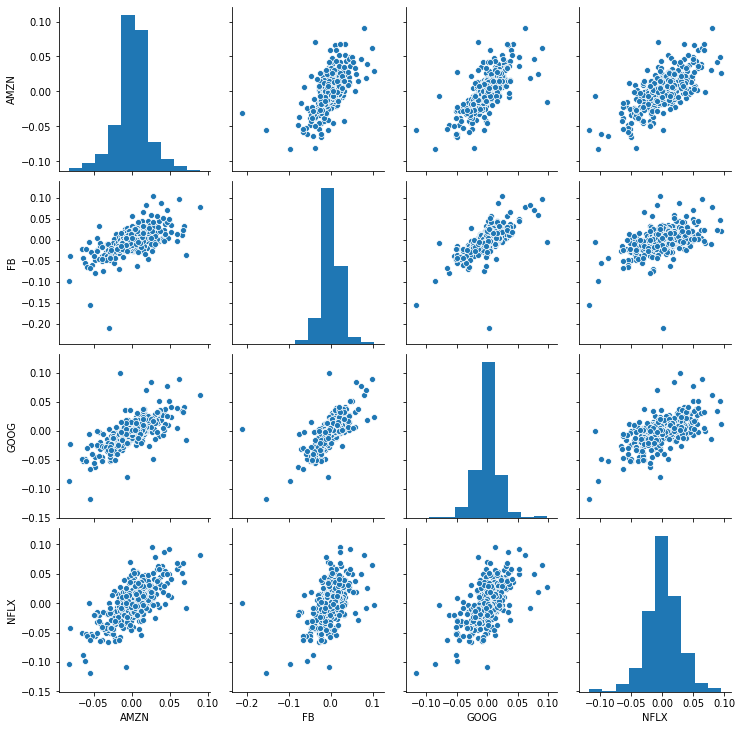

In [4]:
sns.pairplot(data=returns)
plt.show()

In [18]:
returns.corr()

,AMZN,FB,GOOG,NFLX
AMZN,1.000000,0.616917,0.705334,0.692230
FB,0.616917,1.000000,0.704202,0.501130
GOOG,0.705334,0.704202,1.000000,0.589892
NFLX,0.692230,0.501130,0.589892,1.000000


## Basic Calculations

In [19]:
# Initial Weights
eq_w = len_symbols * [1 / len_symbols]

#Risk Free
rf = 0.01

def calculate_return(weights):
    return np.dot(returns.mean(), weights) * 252

def calculate_std_dev(weights):
    return math.sqrt(np.dot(weights, np.dot(returns.cov(), weights)) * 252)

def calculate_sharpe(weights):
    return (calculate_return(weights) - rf) / calculate_std_dev(weights)

In [20]:
calculate_return(eq_w)

0.19663279445461926

In [21]:
calculate_std_dev(eq_w)

0.3101637436253637

In [22]:
calculate_sharpe(eq_w)

0.6017234389588961

## Monte Carlo Simulation of 1,000 portfolios

### Portfolio & Metrics generator

Once we have the weights generated, we can utilize the functions created before to compute the metrics for each of the generated portfolios. With them we can quickly identify the Minimum Variance Portfolio and the Max Sharpe ratio portfolio.

In [10]:
np.random.seed(21)
num_ports = 1000

random_weights = np.random.random((num_ports, len(symbols)))
random_weights = (random_weights.T / random_weights.sum(axis=1)).T


In [11]:
simulations = [(calculate_return(w), calculate_std_dev(w),calculate_sharpe(w)) for w in random_weights]
simulations = np.array(simulations)
simulations[:5]

array([[0.10238043, 0.30961288, 0.29837397],
       [0.25263727, 0.34144171, 0.71062574],
       [0.22408993, 0.3396921 , 0.63024702],
       [0.22483146, 0.33651028, 0.63840979],
       [0.1702555 , 0.30710681, 0.52182333]])

### Printing Results

In [12]:
def print_weights(weights):
    w = [round(i*100,2)for i in weights]
    w = pd.DataFrame(w, columns = ['Weight (%)'], index = returns.columns)
    print("\n",w)

In [13]:
print("Max Sharpe Ratio using Monte Carlo Simulation: {:.3f}".format(simulations[:,2].max()))
print_weights(random_weights[simulations[:,2].argmax(),:])

min_vol_ret = simulations[simulations[:,1].argmin(),0]
min_vol_vol = simulations[simulations[:,1].argmin(),1]

max_sharpe_ret = simulations[simulations[:,2].argmax(),0]
max_sharpe_vol = simulations[simulations[:,2].argmax(),1]

max_ret_ret = simulations[simulations[:,0].argmax(),0]


Max Sharpe Ratio using Monte Carlo Simulation: 0.893

       Weight (%)
AMZN       77.37
FB          3.22
GOOG        6.45
NFLX       12.96


### Scatter Plot with Portfolio Returns

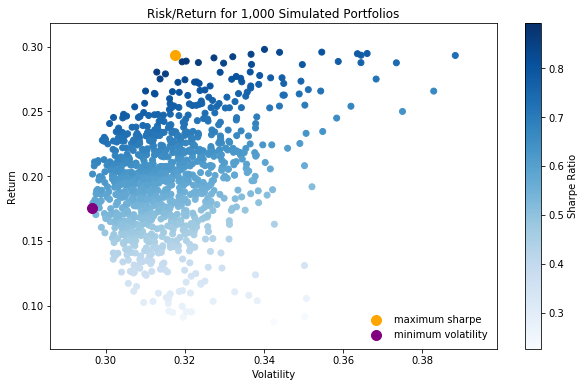

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(simulations[:,1],simulations[:,0], c=simulations[:,2], cmap='Blues')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Risk/Return for 1,000 Simulated Portfolios')
plt.scatter(max_sharpe_vol, max_sharpe_ret,c='orange', s=100, label='maximum sharpe')
plt.scatter(min_vol_vol, min_vol_ret,c='purple', s=100, label='minimum volatility')
plt.legend(frameon=False)
#plt.savefig('montecarlo.png')
plt.show()

### Creating Efficient Frontier

The efficient frontier goes from the return of the Minimum Variance Portfolio up to the maximum return possible with the selected stocks. To calculate the dots between the extremes, we proceed to solve the minimum standard deviation for each of the returns. This optimization is done with a solver function called "minimize" from the SciPy package.

In [15]:
frontier_y = np.linspace(min_vol_ret,max_ret_ret)

frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':lambda eq_w: eq_w.sum() - 1},
            {'type':'eq', 'fun': lambda eq_w: calculate_return(eq_w) - possible_return})
    bounds = len_symbols * [(0, 1)]
    
    result = sco.minimize(calculate_std_dev, eq_w, bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

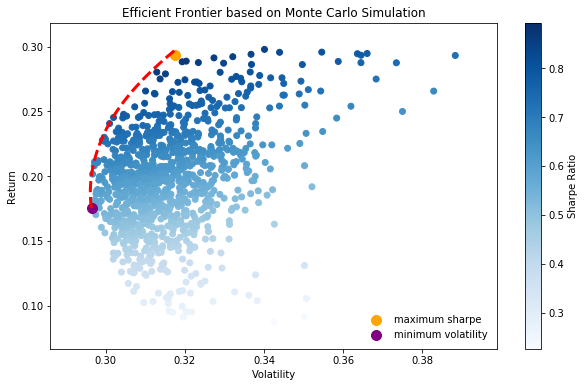

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(simulations[:,1],simulations[:,0], c=simulations[:,2], cmap='Blues')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier based on Monte Carlo Simulation')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.scatter(max_sharpe_vol, max_sharpe_ret,c='orange', s=100, label='maximum sharpe')
plt.scatter(min_vol_vol, min_vol_ret,c='purple', s=100, label='minimum volatility')
plt.legend(frameon=False)
#plt.savefig('frontier.png')
plt.show()


## Computational Optimizer to find best Sharpe Ratio Portfolio

Finally, we utilize the same optimizer than before to find analytically the portfolio with the maximum Sharpe ratio. We set the constrain that the sum of all weights has to sum 1, and the bounds of each individual weights are 0 and 1.

In [17]:
# Set constrains and initial guess
cons = {'type': 'eq', 'fun': lambda eq_w: eq_w.sum() - 1}
bounds = len_symbols * [(0, 1)]

def min_max_sharpe(w):
    return -calculate_sharpe(w)

opt_results = sco.minimize(min_max_sharpe, eq_w, bounds = bounds, constraints=cons)
opt_w = opt_results['x']

print("Computational Optimized weights:")
print_weights(opt_w)
print("\n")
print("Indicators of Optimal Portfolio:")
print("Return {:.3f}, Volatility {:.3f}, Sharpe {:.3f}".format(calculate_return(opt_w), calculate_std_dev(opt_w),calculate_sharpe(opt_w)))


Computational Optimized weights:

       Weight (%)
AMZN       90.12
FB          0.00
GOOG        0.00
NFLX        9.88


Indicators of Optimal Portfolio:
Return 0.316, Volatility 0.326, Sharpe 0.939


<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" align="right" border="0" width="35%" >
</a> <br>